# タイタニックのデータで試す

In [20]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv('./input/train.csv')
df_test = pd.read_csv('./input/test.csv')
df_gender_submission = pd.read_csv('./input/gender_submission.csv')

In [4]:
genders = {'male': 0, 'female': 1} # 辞書を作成
# Sexをgendersを用いて変換
df_train['Sex'] = d試すf_train['Sex'].map(genders)
df_test['Sex'] = df_test['Sex'].map(genders)

# ダミー変数化
df_train = pd.get_dummies(df_train, columns=['Embarked'])
df_test = pd.get_dummies(df_test, columns = ['Embarked'])

# 不要な列の削除
df_train.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

In [5]:
df_train.head(6)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1
5,0,3,0,NaN,0,0,8.4583,0,1,0


In [6]:
X_train = df_train.iloc[:,1:]
Y_train = df_train['Survived']

## scikit-learnからlightGBMを使う

In [9]:
# 3分割交差検証を指定し、インスタンス化
kf = KFold(n_splits=3)

score_list = []

params = {
        'objective': 'binary',
        'metric' : 'binary_error',
        'learning_rate': 0.1,
        'num_leaves' : 300,
        'random_seed' : 1
}

for train_index, test_index in kf.split(X_train, Y_train):
    X_cv_train = X_train.iloc[train_index]
    X_cv_test = X_train.iloc[test_index]
    y_cv_train = Y_train[train_index]
    y_cv_test = Y_train[test_index]

    gbm = lgb.LGBMClassifier(objective='binary',
                        num_leaves = 300,
                        learning_rate = 0.1,
                        )
    gbm.fit(X_cv_train, y_cv_train,
            eval_set = [(X_cv_test, y_cv_test)],
            early_stopping_rounds=10,
            verbose=5)
    
    y_pred = gbm.predict(X_cv_test, num_iteration=gbm.best_iteration_)
    score_list.append(round(accuracy_score(y_cv_test,y_pred)*100,2))
    print(round(accuracy_score(y_cv_test,y_pred)*100,2))

Training until validation scores don't improve for 10 rounds.
[5]	valid_0's binary_logloss: 0.556075
[10]	valid_0's binary_logloss: 0.505685
[15]	valid_0's binary_logloss: 0.485895
[20]	valid_0's binary_logloss: 0.474804
[25]	valid_0's binary_logloss: 0.470811
[30]	valid_0's binary_logloss: 0.4765
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.47018
78.45
Training until validation scores don't improve for 10 rounds.
[5]	valid_0's binary_logloss: 0.529032
[10]	valid_0's binary_logloss: 0.461394
[15]	valid_0's binary_logloss: 0.433835
[20]	valid_0's binary_logloss: 0.423196
[25]	valid_0's binary_logloss: 0.425706
[30]	valid_0's binary_logloss: 0.437602
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.421602
82.49
Training until validation scores don't improve for 10 rounds.
[5]	valid_0's binary_logloss: 0.531366
[10]	valid_0's binary_logloss: 0.460926
[15]	valid_0's binary_logloss: 0.427192
[20]	valid_0's binary_logloss: 0.407025
[25]	valid_0's bin

In [12]:
score_list

[78.45, 82.49, 84.51]

In [10]:
gbm.get_params

<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=300, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)>

In [ ]:
gbm.

In [30]:
df_gender_submission['Survived'] = y_pred

In [32]:
df_gender_submission.to_csv('lightgbm.csv',index = False)

## scikit-learnを使わない

In [7]:
X_train = df_train.iloc[:,1:]
Y_train = df_train['Survived']

# 3分割交差検証を指定し、インスタンス化
skf = KFold(n_splits=3)

params = {
        'objective': 'binary',
        'learning_rate': 0.1,
        'num_leaves' : 300
}


# skf.split(X_train.Ytrain)で、X_trainとY_trainを3分割し、交差検証をする
for train_index, test_index in skf.split(X_train, Y_train):
    X_cv_train = X_train.iloc[train_index]
    X_cv_test = X_train.iloc[test_index]
    y_cv_train = Y_train[train_index]
    y_cv_test = Y_train[test_index]
    
    lgb_train = lgb.Dataset(X_cv_train,y_cv_train)
    lgb_eval = lgb.Dataset(X_cv_test,y_cv_test)
    
    gbm = lgb.train(params = params,
            train_set = lgb_train,
            num_boost_round=50,
            valid_sets=lgb_eval,
            early_stopping_rounds=20,
            verbose_eval = 5)
    
    y_pred = gbm.predict(X_cv_test,num_iteration=gbm.best_iteration)

    # acuuracyを表示
    preds = np.round(gbm.predict(X_cv_test))
    print(round(accuracy_score(y_cv_test,preds)*100,2))

Training until validation scores don't improve for 20 rounds.
[5]	valid_0's binary_logloss: 0.556075
[10]	valid_0's binary_logloss: 0.505685
[15]	valid_0's binary_logloss: 0.485895
[20]	valid_0's binary_logloss: 0.474804
[25]	valid_0's binary_logloss: 0.470811
[30]	valid_0's binary_logloss: 0.4765
[35]	valid_0's binary_logloss: 0.484632
[40]	valid_0's binary_logloss: 0.492978
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.47018
78.45
Training until validation scores don't improve for 20 rounds.
[5]	valid_0's binary_logloss: 0.529032
[10]	valid_0's binary_logloss: 0.461394
[15]	valid_0's binary_logloss: 0.433835
[20]	valid_0's binary_logloss: 0.423196
[25]	valid_0's binary_logloss: 0.425706
[30]	valid_0's binary_logloss: 0.437602
[35]	valid_0's binary_logloss: 0.447486
[40]	valid_0's binary_logloss: 0.459137
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.421602
82.49
Training until validation scores don't improve for 20 rounds.
[5]	valid_0's bin

### cv(cross validation)を簡単に行うことができる

おそらく、scikit-learnからはできなくて、毎回stdまで出してくれるから使いやすい  

- 参考１：https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.cv
- 参考２：https://www.kaggle.com/c/home-credit-default-risk/discussion/58332#339215

In [ ]:
X_train, Y_train

In [14]:
lgb_train = lgb.Dataset(X_train, Y_train)

# LightGBM のハイパーパラメータ
lgbm_params = {
    # ２値分類問題
    'objective': 'binary',
}

In [22]:
lgb.cv

<function lightgbm.engine.cv(params, train_set, num_boost_round=100, folds=None, nfold=5, stratified=True, shuffle=True, metrics=None, fobj=None, feval=None, init_model=None, feature_name='auto', categorical_feature='auto', early_stopping_rounds=None, fpreproc=None, verbose_eval=None, show_stdv=True, seed=0, callbacks=None)>

In [23]:
gbm = lgb.cv(params = lgbm_params,
            train_set = lgb_train,
            num_boost_round=50,
            nfold=5, 
            stratified=False,
            early_stopping_rounds=None,
            verbose_eval = 5)

[5]	cv_agg's binary_logloss: 0.535047 + 0.00731934
[10]	cv_agg's binary_logloss: 0.471216 + 0.0110242
[15]	cv_agg's binary_logloss: 0.442614 + 0.0163243
[20]	cv_agg's binary_logloss: 0.429049 + 0.0228276
[25]	cv_agg's binary_logloss: 0.422689 + 0.0271116
[30]	cv_agg's binary_logloss: 0.423944 + 0.0281816
[35]	cv_agg's binary_logloss: 0.427134 + 0.0300522
[40]	cv_agg's binary_logloss: 0.430943 + 0.032768
[45]	cv_agg's binary_logloss: 0.432811 + 0.0318804
[50]	cv_agg's binary_logloss: 0.438745 + 0.0336889


In [24]:
gbm # 辞書にlossとlossの標準偏差がはいります。

{'binary_logloss-mean': [0.6482755793667876,
  0.6119305411339085,
  0.5820796068247593,
  0.5562550675322665,
  0.5350468296220562,
  0.5179898585549964,
  0.5031262579663032,
  0.4908952052787419,
  0.48089319204408376,
  0.47121597228517215,
  0.4629217688050633,
  0.45681698299009754,
  0.4511793002197833,
  0.44621586476085345,
  0.44261389974510046,
  0.4381098555344062,
  0.43482970639070634,
  0.4331172337372503,
  0.4306414808471235,
  0.4290487872474317,
  0.4265948968903717,
  0.425656346687445,
  0.4244345834574175,
  0.4237613835393471,
  0.42268947471839463,
  0.4226693828798235,
  0.4231409166138893,
  0.42342719963507863,
  0.42361870043574407,
  0.42394372092945193,
  0.42349842464399784,
  0.42441299658276294,
  0.4250617993318698,
  0.42576231838824585,
  0.4271337675316606,
  0.4278185700400381,
  0.42838049887593443,
  0.42908008738834036,
  0.4298710628868685,
  0.43094313805434403,
  0.43201556377356143,
  0.43115551294394666,
  0.4323981777784233,
  0.4323894186

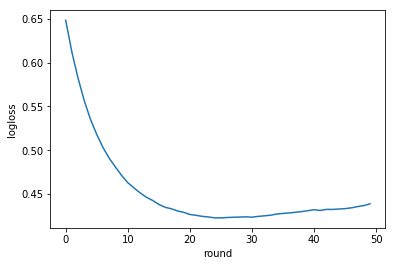

In [28]:
cv_logloss = gbm['binary_logloss-mean']
round_n = np.arange(len(cv_logloss))

plt.xlabel('round')
plt.ylabel('logloss')
plt.plot(round_n, cv_logloss)
plt.show()

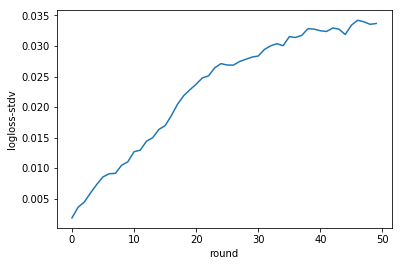

In [31]:
plt.xlabel('round')
plt.ylabel('logloss-stdv')
plt.plot(round_n, gbm['binary_logloss-stdv']);
plt.show()

# （参考）lightGBM関連のリンク集
- 公式：https://github.com/Microsoft/LightGBM
    - example:https://github.com/Microsoft/LightGBM/tree/master/examples
    - parameters:https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst
- 日本語資料
    - [LightGBM ハンズオン \- もう一つのGradient Boostingライブラリ \- Qiita](https://qiita.com/TomokIshii/items/3729c1b9c658cc48b5cb)
    - [Python: LightGBM を使ってみる \- CUBE SUGAR CONTAINER](https://blog.amedama.jp/entry/2018/05/01/081842)
    - [NIPS2017読み会@クックパッドでLightGBMの論文紹介してきた（全発表資料リンク付き） \- tkm2261's blog](http://yutori-datascience.hatenablog.com/entry/2018/01/29/220935)
    - [Santander Product RecommendationのアプローチとXGBoostの小ネタ \- Speaker Deck](https://speakerdeck.com/rsakata/santander-product-recommendationfalseapurotitoxgboostfalsexiao-neta)
  